Examine sensitivity of current best model (Gear-Specific, Multi-Window 
Logistic Model with is-daylight) with respect to degredation of the AIS
data. 

We train as normal, then progessively randomly dropout more and more of
the training data and see how that effects the resulting reported
accuracies.

In [16]:
%matplotlib inline
from __future__ import print_function, division
import sys
sys.path.append('..')
from vessel_scoring import data, utils
from vessel_scoring.models import train_model_on_data
from vessel_scoring.evaluate_model import evaluate_model, compare_models
from IPython.core.display import display, HTML, Markdown
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [17]:
from vessel_scoring.logistic_model import LogisticModel

def make_model(seed=4321):
    return LogisticModel(colspec=dict(
        windows=[1800, 3600, 10800, 21600, 43200, 86400],
        measures=['measure_daylight', 'measure_speed']), order=6, random_state=seed)


In [18]:
def load_data(suffix='', seed=4321, even_split=True):
    # Data supplied by Kristina
    _, train_lline,  valid_lline, test_lline = data.load_dataset_by_vessel(
            '../datasets/kristina_longliner.measures{}.npz'.format(suffix), 
             even_split=even_split, seed=seed)
    _, train_trawl,  valid_trawl, test_trawl = data.load_dataset_by_vessel(
            '../datasets/kristina_trawl.measures{}.npz'.format(suffix), 
             even_split=even_split, seed=seed)
    _, train_pseine, valid_pseine, test_pseine = data.load_dataset_by_vessel(
            '../datasets/kristina_ps.measures{}.npz'.format(suffix), 
            even_split=even_split, seed=seed)

    # Slow transits (used to train models to avoid classifying slow transits as fishing)
    TRANSIT_WEIGHT = 10
    x_tran, xtrain_tran, xcross_tran, xtest_tran = data.load_dataset_by_vessel(
                        '../datasets/slow-transits.measures{}.npz'.format(suffix), 
                         even_split=False, seed=seed)
    xtrain_tran = utils.clone_subset(xtrain_tran, test_lline.dtype)
    xcross_tran = utils.clone_subset(xcross_tran, test_lline.dtype)
    xtest_tran = utils.clone_subset(xtest_tran, test_lline.dtype)
    train_tran = np.concatenate([xtrain_tran, xcross_tran] * TRANSIT_WEIGHT)

    train = {'longliner': np.concatenate([train_lline, valid_lline, train_tran]), 
                'trawler': np.concatenate([train_trawl, valid_trawl, train_tran]),
                'purse_seine': np.concatenate([train_pseine, valid_pseine, train_tran])}
    
    test = {'longliner': test_lline, 
            'trawler': test_trawl, 
            'purse_seine': test_pseine}
    
    return train, test

In [19]:
def _load_test_data(path, mmsi, even_split=True):
    test_data, _, _, _ = data.load_dataset_by_vessel(path, even_split=even_split)
    
    mask = np.zeros(test_data.shape, dtype='bool')
    for m in mmsi:
        mask |= (test_data['mmsi'] == m)
                
    return test_data[mask]

def load_test_data(suffix, mmsi_map, even_split=True):
    # Data supplied by Kristina
    test_lline = _load_test_data(
        '../datasets/kristina_longliner.measures{}.npz'.format(suffix), 
                             mmsi_map['longliner'], even_split=even_split)
    test_trawl = _load_test_data(
        '../datasets/kristina_trawl.measures{}.npz'.format(suffix), 
                            mmsi_map['trawler'], even_split=even_split)
    test_pseine = _load_test_data(
        '../datasets/kristina_ps.measures{}.npz'.format(suffix), 
                            mmsi_map['purse_seine'], even_split=even_split)
    
    return {'longliner': test_lline, 
            'trawler': test_trawl, 
            'purse_seine': test_pseine}

To create the features:

```
python scripts/add_all_features.py --keep 0.5
python scripts/add_all_features.py --keep 0.2
python scripts/add_all_features.py --keep 0.1
python scripts/add_all_features.py --keep 0.05
python scripts/add_all_features.py --keep 0.02
python scripts/add_all_features.py --keep 0.01
python scripts/add_all_features.py --keep 0.002
python scripts/add_all_features.py --keep 0.005
```

In [20]:
EVEN_SPLIT = True

keep_probs = [1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002]

train_data, test_data = load_data(even_split=EVEN_SPLIT)

mmsi_map = {x : set(test_data[x]['mmsi']) for x in ['purse_seine', 'trawler', 'longliner']}

drop_test = {1: load_test_data('', mmsi_map)}
for kp in keep_probs[1:]:
    suffix = '-{}'.format(str(kp).replace('.', ''))
    drop_test[kp] = load_test_data(suffix=suffix, mmsi_map=mmsi_map, even_split=EVEN_SPLIT)

predictions = {}

for gear in ['purse_seine', 'trawler', 'longliner']:
    mdl = make_model()
    train_model_on_data(mdl, train_data[gear])
    
    display(HTML("<h2>{}</h2>".format(gear.replace('_', ' ').title())))
                
    predictions[gear] = []
    for kp in keep_probs:  

        td = drop_test[kp][gear]
            
        raw = mdl.predict_proba(td)[:,1]
        predictions[gear].append((kp, td, raw, (raw > 0.5), td['classification'] > 0.5))

    lines = ["|Keep Prob|Recall|Precision|F1-Score|ROC-AUC|",
             "|---------|------|---------|--------|-------|"]
    for name, td, raw, pred, actual in predictions[gear]:
        fpr, tpr, thresholds = metrics.roc_curve(actual, raw)
        auc = metrics.auc(fpr, tpr)
        lines.append("|{}|{:.2f}|{:.2f}|{:.2f}|{:.2f}|".format(name, 
                                            metrics.recall_score(actual, pred),
                                            metrics.precision_score(actual, pred), 
                                            metrics.f1_score(actual, pred),
                                            auc))

    display(Markdown('\n'.join(lines)))    
    display(HTML("<hr/>"))

Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all
Warning, insufficient items to sample, returning all


|Keep Prob|Recall|Precision|F1-Score|ROC-AUC|
|---------|------|---------|--------|-------|
|1|0.86|0.25|0.39|0.93|
|0.5|0.83|0.25|0.38|0.93|
|0.2|0.79|0.24|0.36|0.92|
|0.1|0.76|0.25|0.37|0.92|
|0.05|0.70|0.26|0.38|0.92|
|0.02|0.50|0.23|0.31|0.89|
|0.01|0.36|0.20|0.26|0.90|
|0.005|0.26|0.36|0.30|0.92|
|0.002|0.14|0.25|0.18|0.96|

|Keep Prob|Recall|Precision|F1-Score|ROC-AUC|
|---------|------|---------|--------|-------|
|1|0.87|0.94|0.91|0.96|
|0.5|0.87|0.94|0.91|0.96|
|0.2|0.85|0.95|0.90|0.96|
|0.1|0.81|0.95|0.88|0.95|
|0.05|0.75|0.96|0.84|0.94|
|0.02|0.60|0.97|0.74|0.91|
|0.01|0.44|0.96|0.60|0.90|
|0.005|0.29|0.96|0.44|0.89|
|0.002|0.15|0.94|0.26|0.90|

|Keep Prob|Recall|Precision|F1-Score|ROC-AUC|
|---------|------|---------|--------|-------|
|1|0.90|0.96|0.93|0.95|
|0.5|0.89|0.96|0.92|0.95|
|0.2|0.87|0.96|0.92|0.95|
|0.1|0.84|0.97|0.90|0.95|
|0.05|0.78|0.97|0.87|0.94|
|0.02|0.65|0.98|0.78|0.92|
|0.01|0.51|0.98|0.67|0.88|
|0.005|0.35|0.97|0.52|0.83|
|0.002|0.17|0.98|0.29|0.85|

The loss of recall of recall / precission as AIS is dropped out is surprisingly low. 
Precision / recall appears to be only modestly effected when dropping out 80% of the
original AIS signal, with the exception of purse seiners, where 50% of the signal can
be dropped with only modest reductions of recall / precision.

In [21]:

def _fishing_hours_per_mmsi(data, preds, mask, max_gap):
    # assumes single vessel (mmmsi)
    indices = np.argsort(data['timestamp'])
    data = data[indices]
    preds = preds[indices]
    thresholded = (preds > 0.5)
    dt = (data['timestamp'][1:] - data['timestamp'][:-1]) / (60 * 60)
    dt = np.minimum(dt, max_gap)
    avg_pred = 0.5 * (preds[1:] + preds[:-1])
    avg_thresh = 0.5 * (thresholded[1:] + thresholded[:-1])
    avg_nominal = 0.5 * (data['classification'][1:] + data['classification'][:-1])
    if mask is not None:
        dt *= (mask[1:] + mask[:-1]) / 2.0
    return (avg_pred * dt).sum(), (avg_thresh * dt).sum(), (avg_nominal * dt).sum()

def fishing_hours(data, preds, mask=None, max_gap=24):
    mmsi = set(data['mmsi'])
    pred_hours = thresh_hours = nominal_hours = 0
    for m in mmsi:
        mmsi_mask = (data['mmsi'] == m)
        p_hours, t_hours, n_hours = _fishing_hours_per_mmsi(data[mmsi_mask], 
                                                            preds[mmsi_mask],
                                                            mask=mask,
                                                            max_gap=max_gap)
        pred_hours += p_hours
        thresh_hours += t_hours
        nominal_hours += n_hours
    return pred_hours, thresh_hours, nominal_hours
    
    
predicted_fishing_hours = {}
threshold_fishing_hours = {}
nominal_fishing_hours = {}
    
for gear in ['purse_seine', 'trawler', 'longliner']:
    
    predicted_fishing_hours[gear] = []
    threshold_fishing_hours[gear] = []
    nominal_fishing_hours[gear] = []
    
    display(HTML("<h2>{}</h2>".format(gear.replace('_', ' ').title())))

    lines = ["|Keep Prob|Predicted|Threshold|Nominal|",
             "|---------|---------|---------|-------|"]
    
    for name, td, raw, pred, actual in predictions[gear]:
        predicted, threshold, nominal = fishing_hours(td, raw)
        predicted_fishing_hours[gear].append(predicted)
        threshold_fishing_hours[gear].append(threshold)        
        nominal_fishing_hours[gear].append(nominal)
        lines.append("|{}|{:.2f}|{:.2f}|{:.2f}|".format(name, 
                                                 predicted,
                                                 threshold,
                                                 nominal))
    display(Markdown('\n'.join(lines)))    
    display(HTML("<hr/>"))
    
    

|Keep Prob|Predicted|Threshold|Nominal|
|---------|---------|---------|-------|
|1|5284.33|3289.73|1021.94|
|0.5|4865.86|3186.61|1024.56|
|0.2|4285.63|2918.19|1126.36|
|0.1|3666.74|2554.19|1110.67|
|0.05|2936.48|2085.61|1054.96|
|0.02|1834.66|1321.96|794.23|
|0.01|1055.99|705.48|560.52|
|0.005|446.11|166.34|338.58|
|0.002|143.95|49.18|132.38|

|Keep Prob|Predicted|Threshold|Nominal|
|---------|---------|---------|-------|
|1|25421.92|14140.21|27823.24|
|0.5|24008.69|13946.78|27544.45|
|0.2|20524.35|12844.56|26824.09|
|0.1|16834.61|11279.86|25193.76|
|0.05|12826.30|8938.30|22441.87|
|0.02|7398.53|5509.09|17577.98|
|0.01|4152.90|3345.67|12843.12|
|0.005|1927.94|1673.80|8664.94|
|0.002|452.66|438.26|4138.02|

|Keep Prob|Predicted|Threshold|Nominal|
|---------|---------|---------|-------|
|1|11783.82|7222.38|14031.74|
|0.5|11554.74|6977.68|14023.77|
|0.2|10954.14|6487.73|13999.10|
|0.1|10122.90|6058.78|13962.78|
|0.05|8742.26|5216.63|13858.64|
|0.02|6053.93|3937.16|12994.46|
|0.01|3968.37|3017.93|11456.78|
|0.005|1989.08|1681.42|8491.71|
|0.002|526.40|497.23|4333.45|

Compare the fishing hours calculated based on predictions with those based on hand 
labelled data. Fishing hours based on prediction are calculated in two ways. 
One by summing up the fishing scores and the other by thresholding the fishing 
scores at 0.5. In both cases, the scores are weighted by the gaps between points,
capped at 12 hours. See functions above for details.

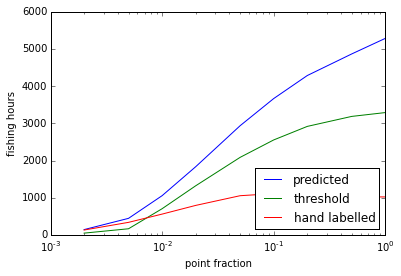

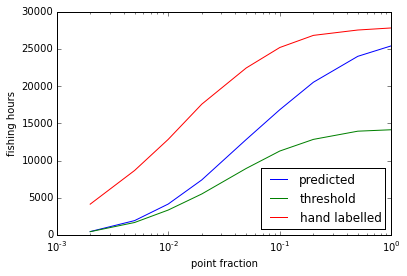

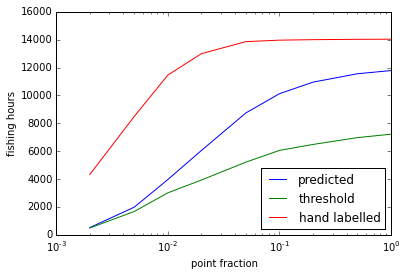

In [22]:
for gear in ['purse_seine', 'trawler', 'longliner']:
    
    
    display(HTML("<h2>{}</h2>".format(gear.replace('_', ' ').title())))

    plt.plot(keep_probs, predicted_fishing_hours[gear], label="predicted")   
    plt.plot(keep_probs, threshold_fishing_hours[gear], label="threshold")   
    plt.plot(keep_probs, nominal_fishing_hours[gear], label="hand labelled")
    plt.xscale('log')
    plt.xlabel('point fraction')
    plt.ylabel('fishing hours')
    plt.legend(loc=4)
    plt.show()
    display(HTML("<hr/>"))

# Fishing hours vs point density

**Note that I'm using just the raw points to evaluate this for now. An additional
experiment would be to use the dropped out points as well and see how that compares**

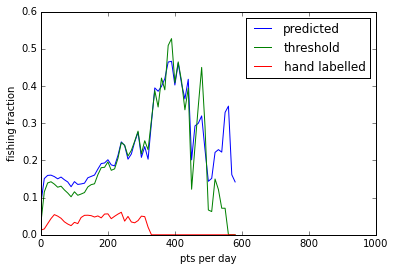

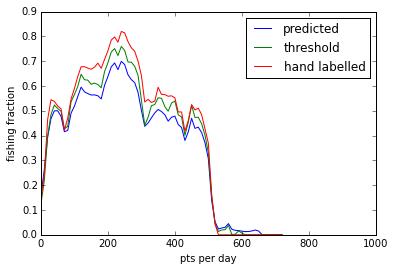

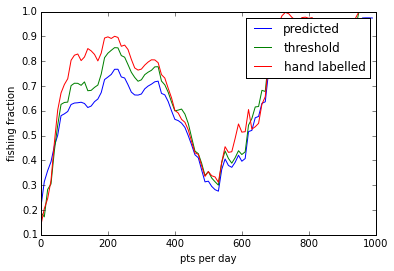

In [23]:
for gear in ['purse_seine', 'trawler', 'longliner']:

    display(HTML("<h2>{}</h2>".format(gear.replace('_', ' ').title())))


    name, td, raw, pred, actual = predictions[gear][0]
    nominal = td['classification']
    predicted = raw
    counts = td['measure_count_86400']
        
    bin_starts = []
    predicted_fp = []
    nominal_fp = []
    threshold_fp = []
    for i in range(100):
        start = i * 10
        stop = (i + 1) * 10
        mask = (counts >= start) & (counts < stop)
        bin_starts.append(start)
        predicted_fp.append((predicted[mask]).mean(), )
        nominal_fp.append((nominal[mask]).mean())
        threshold_fp.append((predicted[mask] > 0.5).mean())

    plt.plot(bin_starts, predicted_fp, label="predicted")
    plt.plot(bin_starts, threshold_fp, label="threshold")
    plt.plot(bin_starts, nominal_fp, label="hand labelled")
    plt.xlabel('pts per day')
    plt.ylabel('fishing fraction')
    plt.legend(loc=1)
    plt.xlim(0,1000)
    plt.show()

/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:36: RuntimeWarning: divide by zero encountered in true_divide
/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in true_divide


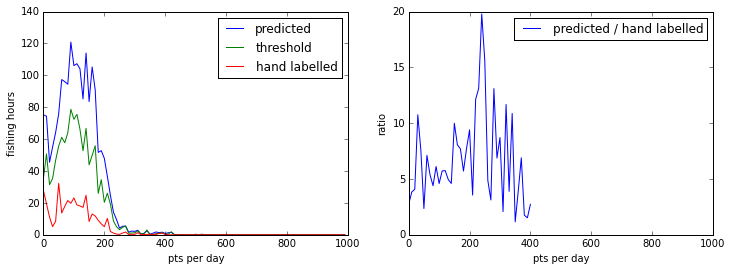

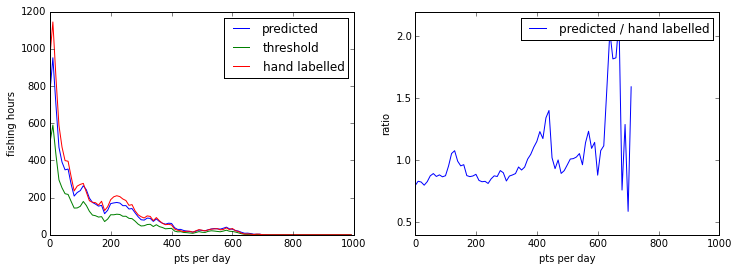

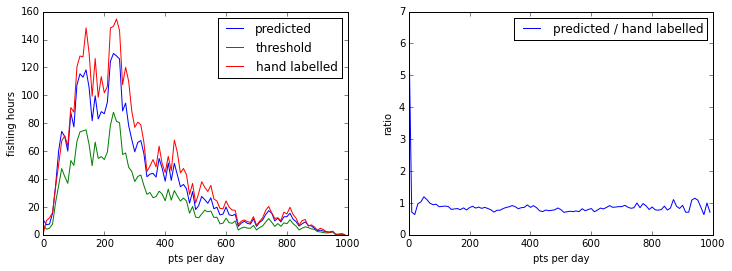

In [44]:
for gear in ['purse_seine', 'trawler', 'longliner']:

    display(HTML("<h2>{}</h2>".format(gear.replace('_', ' ').title())))

    name, td, raw, preds, actual = predictions[gear][0]
    
    plt.figure(figsize=(12,4))

    counts = td['measure_count_86400']
        
    bin_starts = []
    predicted_fp = []
    nominal_fp = []
    threshold_fp = []
    for i in range(100):
        start = i * 10
        stop = (i + 1) * 10
        mask = (counts >= start) & (counts < stop)
        bin_starts.append(start)
        predicted, threshold, nominal = _fishing_hours_per_mmsi(td, raw, mask=mask, max_gap=24)

        predicted_fp.append(predicted)
        nominal_fp.append(nominal)
        threshold_fp.append(threshold)

    plt.subplot(121)
    plt.plot(bin_starts, predicted_fp, label="predicted")
    plt.plot(bin_starts, threshold_fp, label="threshold")
    plt.plot(bin_starts, nominal_fp, label="hand labelled")
    plt.xlabel('pts per day')
    plt.ylabel('fishing hours')
    plt.legend(loc=1)
    plt.xlim(0,1000)
    
    plt.subplot(122)
    plt.plot(bin_starts, np.array(predicted_fp) / nominal_fp, 
             label="predicted / hand labelled")
    plt.xlabel('pts per day')
    plt.ylabel('ratio')
    plt.legend(loc=1)
    plt.xlim(0,1000)
    
    plt.show()

# Variation of Hand Labelled with Point Fraction

Hand labelled data also varies with the point fraction value. How and why?

This turns out to primarily be the results of the 24 hour maximum distance between points.


In [28]:
print(len(predictions["longliner"]), len(keep_probs))

9 9


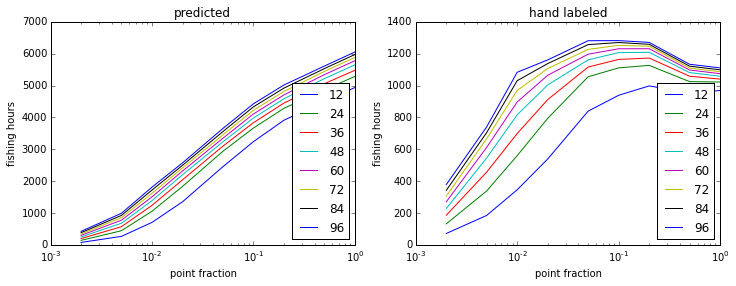

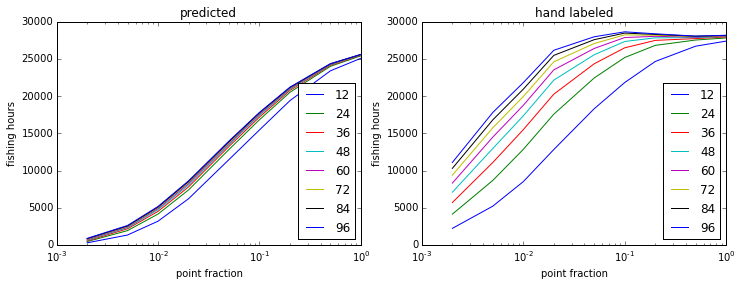

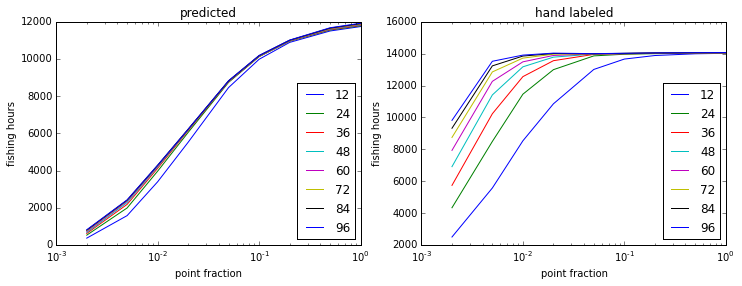

In [37]:
for gear in ['purse_seine', 'trawler', 'longliner']:

    display(HTML("<h2>{}</h2>".format(gear.replace('_', ' ').title())))
    
    plt.figure(figsize=(12,4))
    
    for max_gap in [12, 24, 36, 48, 60, 72, 84, 96]:

        predicted = []
        nominal = []

        for name, td, raw, pred, actual in predictions[gear]:
            p, _, n = fishing_hours(td, raw, max_gap=max_gap)
            predicted.append(p)
            nominal.append(n)
            
        plt.subplot(121)
        plt.plot(keep_probs, predicted, label=str(max_gap))   
        plt.xscale('log')
        plt.xlabel('point fraction')
        plt.ylabel('fishing hours')
        plt.title("predicted")
        plt.legend(loc=4)
        
        plt.subplot(122)
        plt.plot(keep_probs, nominal, label=str(max_gap))   
        plt.xscale('log')
        plt.xlabel('point fraction')
        plt.ylabel('fishing hours')
        plt.title("hand labeled")
        plt.legend(loc=4)
    plt.show()
